- cluster sequences based on Ag1000g and sequencing data thresholds
- compare clustering performance (Ag1000g thresholds have higher resolution)
- filter outlier samples within species (single genotype in a separate cluster)
- filter alleles split between clusters

Manual steps: none

In [1]:
%run common.ipynb

In [2]:
bad_samples = pd.read_csv(BAD_SAMPLES).iloc[:, 0].to_list()
len(bad_samples)

8

In [3]:
seq_data = pd.read_csv(COMB_SEQ)
# remove species ID for compromised samples
seq_data.loc[seq_data.s_Sample.isin(bad_samples), 'species'] = 'unknown'
seq_data.head(1)

,s_Sample,target,consensus,reads,species,combUID
0,Abro-21,13,TCTCCATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATG...,23.0,Anopheles_brohieri,13-0


In [4]:
t_data = pd.read_csv(COMB_THRESHOLDS)
t_data.head(1)

,target,start_insert,end_insert,len_insert,var_ag1k,dist_ag1k,aln_len,ngaps_mean,var_multisp,delta_t
0,0,10356439,10356587,149,5.0,0.033557,233,95.275362,12.0,7.0


## cd-hit-est clustering with two sets of identity thresholds

In [5]:
def clust(ampl, max_var=1, word_len=10):
    
    # subset amplicon data
    ampl_data = seq_data[seq_data.target == ampl]
    # get only unique sequences
    ampl_data = ampl_data[~ampl_data.combUID.duplicated()]
    # write sequences under combUID name
    with open('temp.fa', 'w') as o:
        for (i, row) in ampl_data.iterrows():
            o.write('>{}\n{}\n'.format(row.combUID,
                                       row.consensus))
    
    # cd-hit-est identity definition:
    # number of identical bases in alignment
    # divided by the full length of the shorter sequence
    min_len = ampl_data.consensus.str.len().min()
    identity = 1 - max_var / float(min_len)
    # cd-hit does not work for <0.8 identity
    identity = max(identity, 0.8)
    
    # run clustering
    ! cd-hit-est -i temp.fa -o cl -c {identity} -n {word_len} > cl.log
    # parse clusters into dict
    cl_data = dict()
    with open('cl.clstr') as f:
        for l in f:
            l = l.strip('\n')
            # cluster name
            if l.startswith('>'):
                cluster = 'cl-{}-{}'.format(ampl,
                                            l.split(' ')[1])
            # cluster members
            else:
                seq = l.split('>')[1].split('...')[0]
                cl_data[seq] = cluster
    # clean up
    ! rm cl cl.clstr cl.log temp.fa
    # all input sequences clustered?
    assert len(cl_data) == ampl_data.combUID.nunique()
    
    return cl_data, identity
clust(0)[1]

0.9914529914529915

In [6]:
# ag1k thresholds
gc_clustering = dict()
gc_identities = dict()
for ampl in AMPLS:
    sys.stdout.write('\r'+ampl)
    ampl = int(ampl)
    # variants
    v = t_data.loc[t_data.target == ampl, 'var_ag1k'].iloc[0]
    # clustering
    (c, i) = clust(ampl, v)
    # record
    gc_clustering.update(c)
    gc_identities[ampl] = i
print('\nDone!')
display(len(gc_clustering))
gc_identities

61
Done!


5606

{0: 0.9572649572649573,
 1: 0.9869281045751634,
 2: 0.9482758620689655,
 3: 0.9230769230769231,
 4: 0.9789473684210527,
 5: 0.9465648854961832,
 6: 0.9615384615384616,
 7: 0.9507042253521126,
 8: 0.9541984732824428,
 9: 0.9735099337748344,
 10: 0.9618320610687023,
 11: 0.9416666666666667,
 12: 0.9181818181818182,
 13: 0.9669421487603306,
 14: 0.9748427672955975,
 15: 0.9748427672955975,
 16: 0.9761904761904762,
 17: 0.9612903225806452,
 18: 0.9624060150375939,
 19: 0.9722222222222222,
 20: 0.9792746113989638,
 21: 0.9728260869565217,
 22: 0.9577464788732395,
 23: 0.9278350515463918,
 24: 0.9808917197452229,
 25: 0.9212598425196851,
 26: 0.8876404494382022,
 27: 0.9820359281437125,
 28: 0.9797297297297297,
 29: 0.9861111111111112,
 30: 0.9849624060150376,
 31: 0.9666666666666667,
 32: 0.875,
 33: 0.8901098901098901,
 34: 0.9743589743589743,
 35: 0.9473684210526316,
 36: 0.974025974025974,
 37: 0.952755905511811,
 38: 0.9456521739130435,
 39: 0.9814814814814815,
 40: 0.9411764705882353,


In [7]:
# multispecies thresholds
mu_clustering = dict()
mu_identities = dict()
for ampl in AMPLS:
    sys.stdout.write('\r'+ampl)
    ampl = int(ampl)
    # variants
    v = t_data.loc[t_data.target == ampl, 'var_multisp'].iloc[0]
    # clustering
    (c, i) = clust(ampl, v)
    # record
    mu_clustering.update(c)
    mu_identities[ampl] = i
print('\nDone!')
display(len(mu_clustering))
mu_identities

61
Done!


5606

{0: 0.8974358974358975,
 1: 0.9803921568627451,
 2: 0.9051724137931034,
 3: 0.9038461538461539,
 4: 0.9894736842105263,
 5: 0.9312977099236641,
 6: 0.9,
 7: 0.8802816901408451,
 8: 0.8931297709923665,
 9: 0.9801324503311258,
 10: 0.8244274809160306,
 11: 0.8833333333333333,
 12: 0.9454545454545454,
 13: 0.9173553719008265,
 14: 0.9685534591194969,
 15: 0.9685534591194969,
 16: 0.8988095238095238,
 17: 0.832258064516129,
 18: 0.9097744360902256,
 19: 0.9305555555555556,
 20: 0.9792746113989638,
 21: 0.9836956521739131,
 22: 0.9577464788732395,
 23: 0.8,
 24: 0.9808917197452229,
 25: 0.889763779527559,
 26: 0.8089887640449438,
 27: 0.9640718562874252,
 28: 0.9527027027027027,
 29: 0.9861111111111112,
 30: 0.8,
 31: 0.9809523809523809,
 32: 0.8,
 33: 0.8571428571428572,
 34: 0.9807692307692307,
 35: 0.9532163742690059,
 36: 0.974025974025974,
 37: 0.8582677165354331,
 38: 0.9456521739130435,
 39: 0.9814814814814815,
 40: 0.8,
 41: 0.9054054054054054,
 42: 0.8640776699029127,
 43: 0.860294

In case of multispecies-based clustering, minimum 80% similarity threshold was hit 7 times.

## Compare clustering performance

In [8]:
# combine clustering results with sequencing data
seq_data['ag1k_cluster'] = seq_data.combUID.replace(gc_clustering)
seq_data['multisp_cluster'] = seq_data.combUID.replace(mu_clustering)
clustering_types = ('ag1k_cluster', 'multisp_cluster')

In [9]:
# limit stats calculation to high quality species
hq_seq_data = seq_data[seq_data.species != 'unknown']
display(seq_data.shape, hq_seq_data.shape)

(10057, 8)

(9589, 8)

In [10]:
# species per cluster - indication of merged multispecies clusters 
species_merged_cl = pd.DataFrame({cl:hq_seq_data.groupby([cl,'target'])['species'].nunique().describe()
                                  for cl in clustering_types})
species_merged_cl

,ag1k_cluster,multisp_cluster
count,1951.000000,1353.000000
mean,1.667350,2.254989
std,1.988829,3.016109
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,3.000000
max,41.000000,45.000000


In [11]:
# clusters per species - indications of split species cluster
species_split_cl = pd.DataFrame({cl:hq_seq_data.groupby(['species','target'])[cl].nunique().describe()
                        for cl in clustering_types}) 
species_split_cl

,ag1k_cluster,multisp_cluster
count,2826.000000,2826.000000
mean,1.151097,1.079618
std,0.476893,0.284767
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,6.000000,3.000000


In [12]:
# same sample genotypes split between clusters - indication of excessive splitting of clusters or contamination 
sample_split_cl = pd.DataFrame({cl:hq_seq_data.groupby(['s_Sample','target'])[cl].nunique().describe()
                                for cl in clustering_types}) 
sample_split_cl

,ag1k_cluster,multisp_cluster
count,7224.000000,7224.000000
mean,1.043328,1.029347
std,0.206310,0.170420
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,3.000000,3.000000


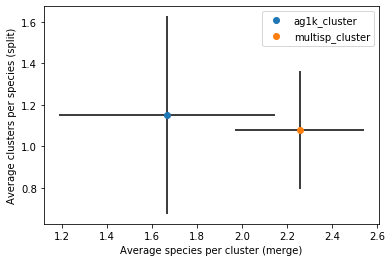

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel('Average species per cluster (merge)')
ax.set_ylabel('Average clusters per species (split)')
for cl in clustering_types:
    mean_merge = species_merged_cl.loc['mean',cl]
    std_merge = species_merged_cl.loc['std',cl]
    mean_split = species_split_cl.loc['mean',cl]
    std_split = species_split_cl.loc['std',cl]
    ax.plot(mean_merge,
            mean_split, 'o', label=cl)
    ax.vlines(mean_merge, mean_split-std_split, mean_split+std_split)
    ax.hlines(mean_split, mean_merge-std_split, mean_merge+std_split)
    ax.legend()

Clustering with multi-species thresholds results in significant increase of merging several species in one cluster compared to ag1000g derived thresholds. On the other hand, decrease of split of species between clusters is quite moderate, thus use of ag1000g thresholds would give a more fine-grained picture without much false splits. In principle, the difference could be more pronounced for amplicons where difference between ag1k and multisp thresholds is the biggest.

# Filtering

In [14]:
# set clustering column to be used for filtering
cl_col = 'ag1k_cluster'

## Outlier samples within species

In [15]:
# find cases where genotypes of a single species are split between clusters 
cl_per_spt = hq_seq_data.groupby(['species','target'])[cl_col].nunique()
multicl_per_spt = cl_per_spt[cl_per_spt > 1].reset_index()
multicl_per_spt.describe()

,target,ag1k_cluster
count,328.000000,328.000000
mean,31.716463,2.301829
std,16.092112,0.679807
min,0.000000,2.000000
25%,18.000000,2.000000
50%,32.000000,2.000000
75%,45.250000,2.000000
max,61.000000,6.000000


In [16]:
# species with split genotypes
(cl_per_spt > 1).sum(level='species') \
          .sort_values(ascending=False).head(10)

species
Anopheles_hyrcanus       34.0
Anopheles_nili           22.0
Anopheles_tenebrosus     20.0
Anopheles_theileri       19.0
Anopheles_rampae         18.0
Anopheles_coustani       17.0
Anopheles_ziemanni       17.0
Anopheles_gambiae        16.0
Anopheles_coluzzii       16.0
Anopheles_tessellatus    13.0
Name: ag1k_cluster, dtype: float64

In [17]:
# targets with split genotypes
(cl_per_spt > 1).sum(level='target') \
          .sort_values(ascending=False).head(10)

target
50    16.0
19    14.0
47    14.0
40    13.0
16    12.0
30    12.0
32    12.0
41    12.0
43    12.0
18    12.0
Name: ag1k_cluster, dtype: float64

Top targets also have significant number of within-species distances higher than ag1k threshold (see 3_distances notebook)

In [18]:
# clusters containing only a single sample from the species
# TODO - double-check that this actually works as expected
outlier_gt = []
for _, r in multicl_per_spt.iterrows():
    # subset sequencing data to problematic species and target
    sub_data = hq_seq_data[(hq_seq_data.species == r.species) & 
                         (hq_seq_data.target == r.target)]
    # count samples per cluster
    sp_group = sub_data.groupby(['species','target',cl_col])['s_Sample'].unique()
    # one off - one sample per cluster for a given species-target
    outlier_gt.append(sp_group[sp_group.apply(lambda x: len(x)) == 1])
# convert to series
outlier_gt = pd.concat(outlier_gt).apply(lambda x: x[0])
display(outlier_gt.shape)
outlier_gt.head()

(292,)

species             target  ag1k_cluster
Anopheles_aconitus  29      cl-29-13        VBS00055
                            cl-29-4         VBS00053
                    41      cl-41-15        VBS00053
                            cl-41-21        VBS00055
                    43      cl-43-2         VBS00053
Name: s_Sample, dtype: object

In [19]:
# most frequently excluded samples
outlier_gt.value_counts().head(10)

Azie-334                                      13
VBS00149                                      13
Acol-645                                       9
VBS00115                                       9
Apal-257                                       7
VBS00122                                       7
VBS00112                                       7
Apal-81                                        7
VBS00108                                       7
anopheles-sinensis-sinensisscaffoldsasins2     6
Name: s_Sample, dtype: int64

In [20]:
# exclude reference genomes from outliers - those are expected to be ground truth
display(outlier_gt.shape)
outlier_gt = outlier_gt[~outlier_gt.str.startswith('anopheles')]
display(outlier_gt.shape)

(292,)

(273,)

In [21]:
outlier_gt = outlier_gt.reset_index()

In [22]:
# write file
outlier_gt.to_csv(OUTLIER_GENOTYPES, index=False, sep='\t')
! head {OUTLIER_GENOTYPES}

species	target	ag1k_cluster	s_Sample
Anopheles_aconitus	29	cl-29-13	VBS00055
Anopheles_aconitus	29	cl-29-4	VBS00053
Anopheles_aconitus	41	cl-41-15	VBS00053
Anopheles_aconitus	41	cl-41-21	VBS00055
Anopheles_aconitus	43	cl-43-2	VBS00053
Anopheles_aconitus	43	cl-43-3	VBS00055
Anopheles_aconitus	52	cl-52-24	VBS00053
Anopheles_aconitus	52	cl-52-31	VBS00055
Anopheles_aconitus	55	cl-55-10	VBS00053


In [23]:
# get outlier sequence status by matching original sequences with outliers on 4 cols
seq_data = pd.merge(seq_data, 
                    outlier_gt, 
                    on=('species','target','ag1k_cluster','s_Sample'), 
                    indicator=True, 
                    how='outer')
# make sure no unmatched genotypes in outlier exist
assert (seq_data['_merge'] == 'right_only').sum() == 0

In [24]:
# convert indicator to outlier genotype
seq_data = seq_data.rename(columns={'_merge':'outlier_genotype'})
seq_data['outlier_genotype'] = seq_data['outlier_genotype'] \
        .replace({'left_only':False,
                  'both':True})

## Filter allelic splits

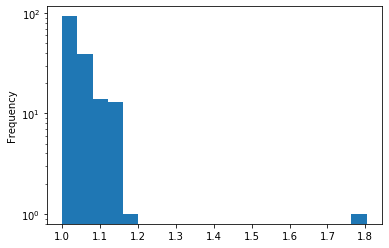

In [25]:
# for all samples
cl_per_sample = seq_data.groupby(['s_Sample','target']) \
                             [cl_col].nunique()
                       
cl_per_sample.mean(level='s_Sample') \
      .sort_values(ascending=False) \
      .plot.hist(bins=20, logy=True);

In [26]:
split_alleles = cl_per_sample[cl_per_sample > 1].reset_index()

In [27]:
# total number of split allelic genotypes
split_alleles.shape

(363, 3)

In [28]:
# most frequently split samples - cross-contamination?
split_alleles.s_Sample.value_counts().head()

VBS00145    40
VBS00112     9
VBS00149     9
Athe-1       8
Athe-6-1     8
Name: s_Sample, dtype: int64

In [29]:
# most frequently split targets - overly specific clustering
# amplicons are similar to the ones identified in outlier genotypes
split_alleles.target.value_counts().head(10)

50    25
47    18
17    17
16    17
32    17
10    16
30    15
40    15
43    13
19    12
Name: target, dtype: int64

In [30]:
# write to file
split_alleles.to_csv(SPLIT_ALLELES, index=False, sep='\t')
! head {SPLIT_ALLELES}

s_Sample	target	ag1k_cluster
Abro-30	28	2
Acar-191	16	2
Acar-192	10	2
Acar-192	16	2
Acar-192	19	2
Acar-192	37	2
Acar-192	41	2
Acar-192	55	2
Acar-193	10	2


In [31]:
seq_data = pd.merge(seq_data, 
                    split_alleles[['s_Sample','target']], 
                    on=['s_Sample','target'], 
                    indicator=True, 
                    how='outer')
# make sure no unmatched genotypes in outlier exist
assert (seq_data['_merge'] == 'right_only').sum() == 0

In [32]:
# convert indicator to outlier genotype
seq_data = seq_data.rename(columns={'_merge':'split_alleles'})
seq_data['split_alleles'] = seq_data['split_alleles'] \
        .replace({'left_only':False,
                  'both':True})

# Check and write

In [33]:
seq_data.head()

,s_Sample,target,consensus,reads,species,combUID,ag1k_cluster,multisp_cluster,outlier_genotype,split_alleles
0,Abro-21,13,TCTCCATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATG...,23.0,Anopheles_brohieri,13-0,cl-13-18,cl-13-11,False,False
1,Abro-21,17,GGTCTAGACCCGGAAGCCCTCACCGGCAAATACCCGGTAAGTGTTT...,14.0,Anopheles_brohieri,17-0,cl-17-8,cl-17-5,False,False
2,Abro-21,18,AAAAAGGATGAGGTGAGTACCAGACTCCTCCCAGAATGATTATAAT...,14.0,Anopheles_brohieri,18-0,cl-18-21,cl-18-17,False,False
3,Abro-21,19,TATTTGTCCACCTTTTGCCGACCGAGTTTTCTTGCCCGAGACGCGT...,23.0,Anopheles_brohieri,19-0,cl-19-41,cl-19-22,False,False
4,Abro-21,24,AATGTAGCCCCGAGCGCGAAGCCGTGAAGCTTCTGCGCGCCACCTC...,36.0,Anopheles_brohieri,24-0,cl-24-1,cl-24-1,False,False


In [34]:
seq_data.to_csv(CLUSTERING, index=False)